The Tennis Tournament in 2019
-- 

Introduction

- Our group's topic is about the tennis tournaments and players involved. There are many players from different regions with a wide range of ages and skills competing to win. These players are ranked based on their capabilities.

- In the data analysis, our group wants to predict **How a player's age, aces and serve points relates to the number of matches they won in 2019's tournaments**.
  
- The dataset is about **Game Results for Top 500 Players from 2017-2019** for many tennis tournaments, which contains various tennis player's information such as rank, age, etc. And for our prediction, we are only containing the **All tournaments** in **2019** for answering the question. We are using the tournament date, winner's average age, name, aces, and serve points. 

In [1]:
#Load required libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
#Load the 2019 tennis match data from the web
atp <- read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2019.csv") |>
    select(tourney_date, winner_name, winner_age, w_ace, w_svpt)

Rows: 2806 Columns: 49
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (14): tourney_id, tourney_name, surface, tourney_level, winner_entry, wi...
dbl (35): draw_size, tourney_date, match_num, winner_id, winner_seed, winner...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
#We each row of the data frame to have the winner's name, and a column for thier aces, serve points, wins
# and average ages.

#Create a data frame with the total aces and serve points for each player
atp_points <- atp |>
    group_by(winner_name) |>
    summarize(aces = sum(w_ace), serve_points = sum(w_svpt))

#Create a vector with the number of wins for each player
atp_wins <- atp |>
    group_by(winner_name) |>
    summarize(wins = n()) |>
    pull(wins)

#Create a vector with the average age of each player. Since the age variable in this dataset has many
#decimal places take the average age of a player over the year.
atp_age <- atp |>
    group_by(winner_name) |>
    summarize(age = mean(winner_age)) |>
    mutate(age = round(age, 0)) |>
    pull(age)

#Combine into one data frame
atp_data <-  bind_cols(atp_points, wins = atp_wins) |>
    bind_cols(age = atp_age)
#atp_data

In [4]:
#Split the data
set.seed(1)
atp_split <- initial_split(atp_data, prop = 0.75, strata = wins)
atp_training <- training(atp_split)
atp_testing <- testing(atp_split)

In [5]:
#Constructing useful table out of training data (number of observations / missing values for each variable)
atp_missing <- count(atp_training, name = "observations") |>
    mutate(na_vals = sum(is.na(atp_training)))
atp_missing

observations,na_vals
<int>,<int>
181,120


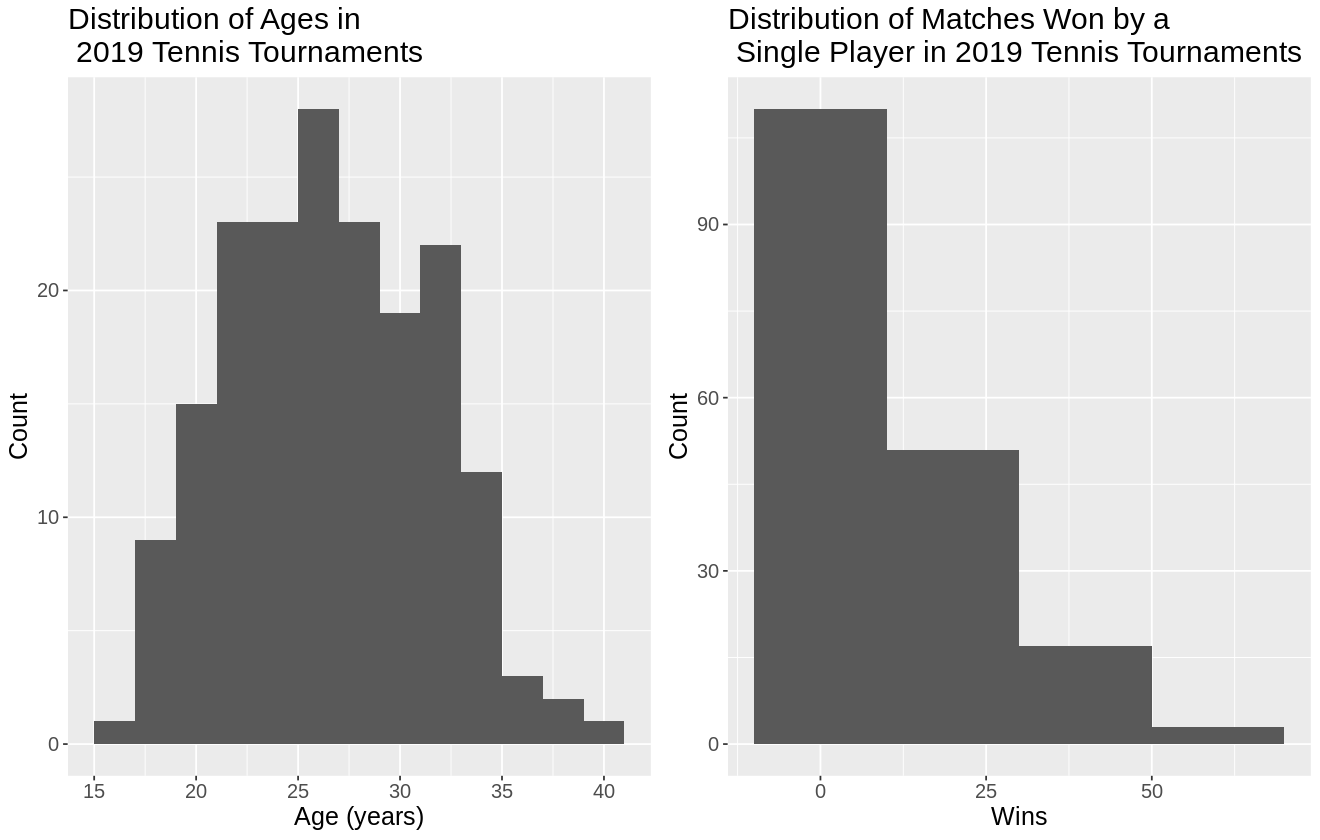

In [6]:
#Age distribution visualization
options(repr.plot.height = 7, repr.plot.width = 11)
age_hist <- ggplot(atp_training, aes(x = age)) +
    geom_histogram(binwidth = 2) +
    labs(x = "Age (years)", y = "Count",
         title = "Distribution of Ages in \n 2019 Tennis Tournaments") +
    theme(text = element_text(size = 15))
win_hist <- ggplot(atp_training, aes(x = wins)) +
    geom_histogram(binwidth = 20) +
    labs(x = "Wins", y = "Count",
     title = "Distribution of Matches Won by a \n Single Player in 2019 Tennis Tournaments") +
    theme(text = element_text(size = 15))
plot_grid(age_hist, win_hist, ncol = 2)

In [7]:
# Define the model specification for linear regression
linear_reg_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

In [8]:
# Define the formula for the model
formula <- wins ~ age + aces + serve_points

In [9]:
# Fit the linear regression model
linear_reg_fit <- linear_reg_spec |>
  fit(formula, data = atp_training)

In [10]:
# Predict on the training data
predictions <- predict(linear_reg_fit, new_data = atp_training) |>
  bind_cols(atp_training) |>
  rename(predicted_wins = .pred)

In [11]:
#------Note! This is for method and result people------------

#Extract out cofficients out (ages, serve points, aces)
model_coefficients <- summary(linear_reg_fit$fit)$coefficients
model_coefficients
# Here's a note for method people:
# For age esimate you saw in the small table below:
# A negative coefficient would indicate that an increase in age is associated with fewer wins.
# Similar works for aces estimate and sever points estimate:
# A positive value means that more aces results in an increase in the number of wins.
# for serve points, positive means winning more serve points is good for the number of matches won,
# they can work in another way around means if it's negative then means more ... (aces, serve points) is actually not good in ...(wins)
#you can delete this part after 
#--------------------------------------------------------------

# Actual vs Predicted Wins Visualization
wins_comparsion_plot <- ggplot(predictions, aes(x = wins, y = predicted_wins)) +
                        geom_point(alpha = 0.5) +
                        geom_abline(slope = 1, intercept = 0, col = "red", linetype = "dashed") +
                        labs(x = "Actual Wins (Num)", y = "Predicted Wins (Num)",
                        title = "Predicted vs Actual Wins based on Aces and Serve Points") +
                        theme_minimal()

#------Another Note for the above visualization--------
# This visualization *wins_comparsion_plot* is for the predictive wins made by the linear regression model
# this is the relation between the actual wins of players and the prediction of the wins
# Why is this form? Because i have tried a lot of variants and the aces and serve points did
# not actually contribute that much in the win rates, so i've decided to merge them into one
# graph of the prediction of the wins. 

# Each POINT on the graph represents an individual player. 
# The x is the number of matches the player actually won in 2019,
# and the y is the number of matches the regression model predicts
# they should have won based on their age, aces, and serve points.

# For the RED DASHED LINE: This is the line of perfect prediction. 
# If every point fell on this line, it would mean that the model's predictions were exactly accurate (which is not)
# I used dashed line because it would make the graph easier to look

# For Points' Distribution: how the points spread around the red dashed line indicates the model's accuracy. 
# Points close to the line suggest accurate predictions, while points far from the line means just less accurate.
#you can delete this note after
#---------Note Ends here---------------------------------

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.438594570,0.8396209991,0.5223721,6.023990e-01
age,-0.025216460,0.0297256523,-0.8483064,3.979996e-01
aces,-0.003185837,0.0021457437,-1.4847240,1.403062e-01
serve_points,0.013139322,0.0002628514,49.9876397,8.630604e-81


In [12]:
# Analysis to visualize how age affects wins
# Calculate average aces and serve points for use in predictions
avg_aces <- mean(atp_training$aces, na.rm = TRUE)
avg_serve_points <- mean(atp_training$serve_points, na.rm = TRUE)

In [13]:
# Generate a new data frame for prediction across a range of ages
age_range <- data.frame(age = seq(min(atp_training$age, na.rm = TRUE), 
                                  max(atp_training$age, na.rm = TRUE), 
                                  length.out = 100),
                        aces = avg_aces,
                        serve_points = avg_serve_points)

In [14]:
# Predict wins using the model across the age range
age_predictions <- predict(linear_reg_fit, new_data = age_range) |>
  bind_cols(age_range) |>
  rename(predicted_wins = .pred)

In [15]:
# Plot age against predicted wins
ages_plot <- ggplot(age_predictions, aes(x = age, y = predicted_wins)) +
                              geom_line() +
                              scale_x_continuous(breaks = seq(from = floor(min(age_predictions$age)), 
                                  to = ceiling(max(age_predictions$age)), 
                                  by = 1)) +
                              labs(x = "Age (years)", y = "Predicted Wins (Num)",
                              title = "Predicted Wins vs. Player Age") +
                              theme_minimal()

Warning message:
“Removed 60 rows containing missing values or values outside the scale range
(`geom_point()`).”


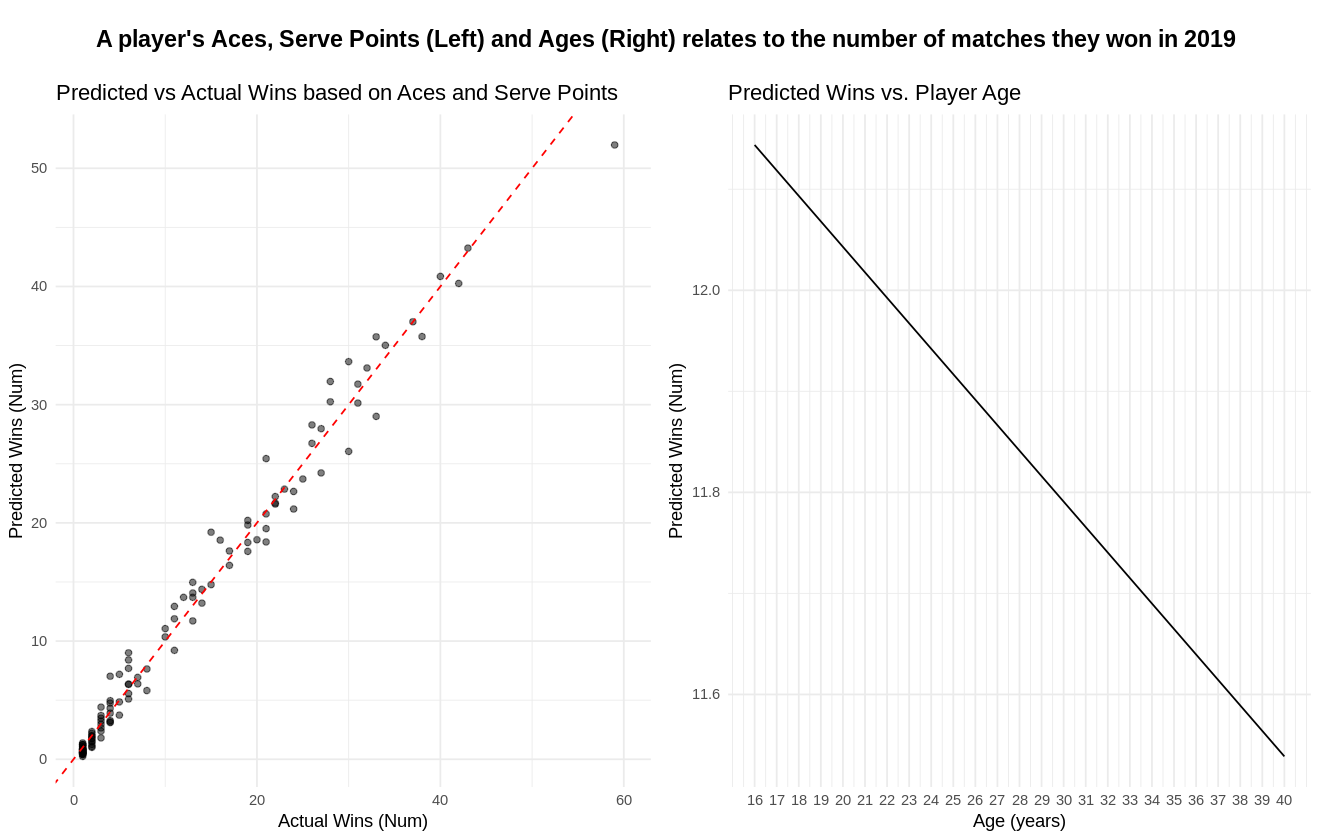

In [16]:
# Add an overall title
combined_plot <- plot_grid(wins_comparsion_plot, ages_plot, ncol = 2)
overall_title <- ggdraw() + 
  draw_label("A player's Aces, Serve Points (Left) and Ages (Right) relates to the number of matches they won in 2019", 
             fontface = 'bold', x = 0.5, hjust = 0.5) +
  theme(plot.margin = margin(0, 0, 0, 7))
final_plot <- plot_grid(overall_title, combined_plot, ncol = 1, rel_heights = c(0.1, 1))
final_plot

**Methods** (from proposal)

To investigate the expected wins across several age groups for major tennis tournaments in 2019, we will employ a regression model. To do this we will split the data into a training and testing set to ensure the model is accurat. We will use K-nearest neighbours regression to construct a model, train it with the training data set, and evaluate its performance using cross-validation.

For this analysis, we will focus on the following columns from the data set based in 2019: tourney_date, winner_a, w_ace, w_svpt. Using the predictor variables age, aces, and serve points the regression model will predict the expected number of wins a player will get based on their age, aces and number of serve points.



**Expected outcomes and significance** (from proposal)

We anticipate our regression model will accurately predict the expected number of wins players will get across a variety of age groups in major tournaments. 

Understanding ese valuesewillan provide valuable insigts into the performance of athletewith n regard to their age. This model can aid players, coaches, and analysts in strategizing training regimes, player selection, and scheduling.

Future investigations could explore the impact of additional variables to create more accuracy in determining expected winsrate of an age group suchthe number of double faults or saved break pointsaces with respect to age. Furthermore, extending the set to include other major tournaments in the from several years could a more comprehensive understanding of age-related performance trends in professional tennis.


**Discussion**

**References**

Aku, Y., & Yang, C. B. (2023). The relative age effect among Chinese junior men's tennis players and its impact on sports performance. PloS one, 18(10), e0292443. https://doi.org/10.1371/journal.pone.0292443

Cui, Y., Gómez, M. Á., Gonçalves, B., & Sampaio, J. (2018). Performance profiles of professional female tennis players in grand slams. PloS one, 13(7), e0200591. https://doi.org/10.1371/journal.pone.0200591

Sackmann, J. (2024). atp_matches_2019. tennis_atp. https://github.com/JeffSackmann/tennis_atp

Zháněl, J., Válek, T., Bozděch, M., & Agricola, A. (2022). The relative age effect in top 100 elite female tennis players in 
2007-2016. PloS one, 17(11), e0276668. https://doi.org/10.1371/journal.pone.0276668

